Universidad de Costa Rica  <br>
CI-0148 Aprendizaje Máquina <br>
Período: 2022-I <br>
Docente: Pablo Sauma Chacón <br>
Estudiante: Jose Pablo Mora Villalobos <br>
Carné: B85326 <br>
***

# Laboratorio 1

Objetivo: Familiarizar al estudiante con el análisis de componentes principales, la lectura de gráficos y la utilización de bibliotecas en Python.

[Descripción del laboratorio](https://docs.google.com/document/d/1_9O-Q8eDvI_j62bLy8y1mRvB55f06xaYouI2_TSWZ74/edit)

## 1. Importar el dataset y realizar limpieza

EL dataset se importa con pandas. Además se importan las librerías de `numpy` y `matplotlib`

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("titanic.csv",na_values=None)
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Las columnas del id del pasajero y nombre (`PassengerId`, `Name`) no aportan mucho al análisis de los datos porque son únicos para cada persona, por lo tanto se eliminan.

In [101]:
df.drop(['PassengerId', 'Name'],axis='columns', inplace=True)
df.head()


,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,female,35.0,1,0,113803,53.1000,C123,S
4,0,3,male,35.0,0,0,373450,8.0500,NaN,S


También se analizan los datos de las variables categóricas para ver si se debe eliminar alguna otra columna.

In [102]:
for i in df:
    if(df[i].dtype=='object'):
        print(i, len(df[i].value_counts()))

Sex 2
Ticket 929
Cabin 186
Embarked 3


Como las variables categóricas de tiquete y cabina tienen muchos valores únicos, se eliminan para poder hacer técnicas de `one-hot encoding` sin agregar demasiada dimensionalidad. Además tampoco aportan mucho al análisis de los datos. A pesar de que `Embarked` no tiene muchos valores, decidí eliminarlo porque considero que el lugar donde se subieron las personas no tiene mucha relación con los demás datos.

Por último, se eliminas entradas que contengan valores nulos.

In [103]:
df.drop(['Cabin', 'Ticket','Embarked'],axis='columns', inplace=True)
print('Cant de entradas antes de eliminar nulos: ', df.shape[0])
df = df.dropna()
print('Cant de entradas después de eliminar nulos: ', df.shape[0])
df.head()


Cant de entradas antes de eliminar nulos:  1309
Cant de entradas después de eliminar nulos:  1045


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,male,22.0,1,0,7.2500
1,1,1,female,38.0,1,0,71.2833
2,1,3,female,26.0,0,0,7.9250
3,1,1,female,35.0,1,0,53.1000
4,0,3,male,35.0,0,0,8.0500


In [104]:
print("Tipos de datos:\n",df.dtypes)

Tipos de datos:
 Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
dtype: object


Se realiza el cambio de las variables categóricas con `one-hot encoding`.

In [105]:
df = pd.get_dummies(df,columns=['Survived','Pclass','Sex'])
df.tail()

,Age,SibSp,Parch,Fare,Survived_0,Survived_1,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
1300,3.0,1,1,13.775,0,1,0,0,1,1,0
1302,37.0,1,0,90.000,0,1,1,0,0,1,0
1303,28.0,0,0,7.775,0,1,0,0,1,1,0
1305,39.0,0,0,108.900,0,1,1,0,0,1,0
1306,38.5,0,0,7.250,1,0,0,0,1,0,1


### 2. Creación de la clase myPCA para encontrar los componentes principales de un dataset.

In [106]:
class myPCA:
    def __init__(self, data):
        self.C = self.getPCA(data)
    
    def getPCA(self, data):
        #centrar y reducir
        self.centered_matrix = self.centerReduce(data)

        #matriz correlaciones
        self.corr_mat = self.corr_matrix(self.centered_matrix)

        # valores y vectores propios
        self.V = self.v_matrix(self.corr_mat)

        # La inicercia de cada columna se calcula a partir de los valores propios 
        # de la matriz de correlaciones dividido entre la cantidad de columnas
        self.inertia = -np.sort(-np.linalg.eigh(self.corr_mat)[0]/self.corr_mat.shape[1])*100
        
        # C corresponde a la multiplicación de la matriz centrada y reducida por la matriz V
        return np.matmul(self.centered_matrix,self.V)
        
    # Método encargado en centrar y reducir la matriz de datos
    def centerReduce(self, data):
        matrix = np.ndarray(data.shape)
        num_col = data.shape[1]
        for col in range(num_col):
            mean = np.mean(data[:,col])
            std = np.std(data[:,col])
            matrix[:,col] = (data[:,col]-mean)/std # restar la media y dividir por la des. estandar cada dato
        return matrix
    
    # La matriz de correlación corresponde a multiplicar la transpuesta por 
    # la matriz de datos y dividirlo por la cantidad de filas
    def corr_matrix(self, data):
        return np.matmul(data.transpose(),data)/data.shape[0]
    
    # La matriz v corresponde a los vectores propios de la matriz de correlaciones
    # de forma que cada vector es una columna de la matriz y están de mayor a menor
    # de acuerdo al valor propio asociado
    def v_matrix(self, data):
        v_matrix = np.ndarray(data.shape)
        eigh_vals = np.abs(np.linalg.eigh(data)[0])
        eigh_vecs = np.linalg.eigh(data)[1]
        for i in range(v_matrix.shape[1]):
            max_index = np.argmax(eigh_vals)
            v_matrix[:,i]= eigh_vecs[:,max_index]

            eigh_vals = np.delete(eigh_vals,max_index)
            eigh_vecs = np.delete(eigh_vecs,max_index,axis=1)
        return v_matrix

        # Imprimir la información de las primeras dos columnas de la matriz de componentes principales
    # coloreados a partir de un valores específico
    def plot_PCA(self, var):
        plt.scatter(np.ravel(self.C[:,0]),np.ravel(self.C[:,1]),c = ['b' if i==1 else 'r' for i in var])
        plt.xlabel('PCA 1 (%.2f%% inertia)' % (self.inertia[0],))
        plt.ylabel('PCA 2 (%.2f%% inertia)' % (self.inertia[1],))
        plt.title('PCA')



In [107]:
# Imprimir el circulo de correlaciones
def plot_corr_circle(data, col_corr):
    plt.figure(figsize=(15,15))
    plt.axhline(0, color='b')
    plt.axvline(0, color='b')
    for i in range(0, data.shape[1]):
        plt.arrow(0,0, col_corr[i, 0],  # x - PC1
                    col_corr[i, 1],  # y - PC2
                    head_width=0.05, head_length=0.05)
        plt.text(col_corr[i, 0] + 0.05, col_corr[i, 1] + 0.05, data.columns.values[i])
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an),color="b")  # Circle
    plt.axis('equal')
    plt.title('Correlation Circle')
    plt.show()


Una vez se tenga la clase para calcular el pca, se calculan los distintos componentes a partir de una matriz de `numpy` con los datos del dataset.

Se grafican además los valores del PCA con respecto al valor de `Survived_1` para visualizar los pasajeros que sobrevivieron en azul y los que no en rojo.

Por último se grafica el círculo de correlaciones para mostrar las relaciones que tiene cada columna. 

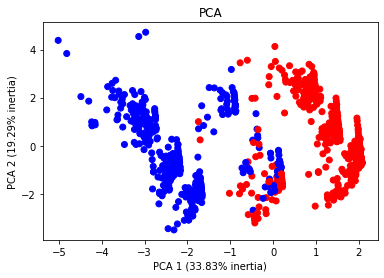

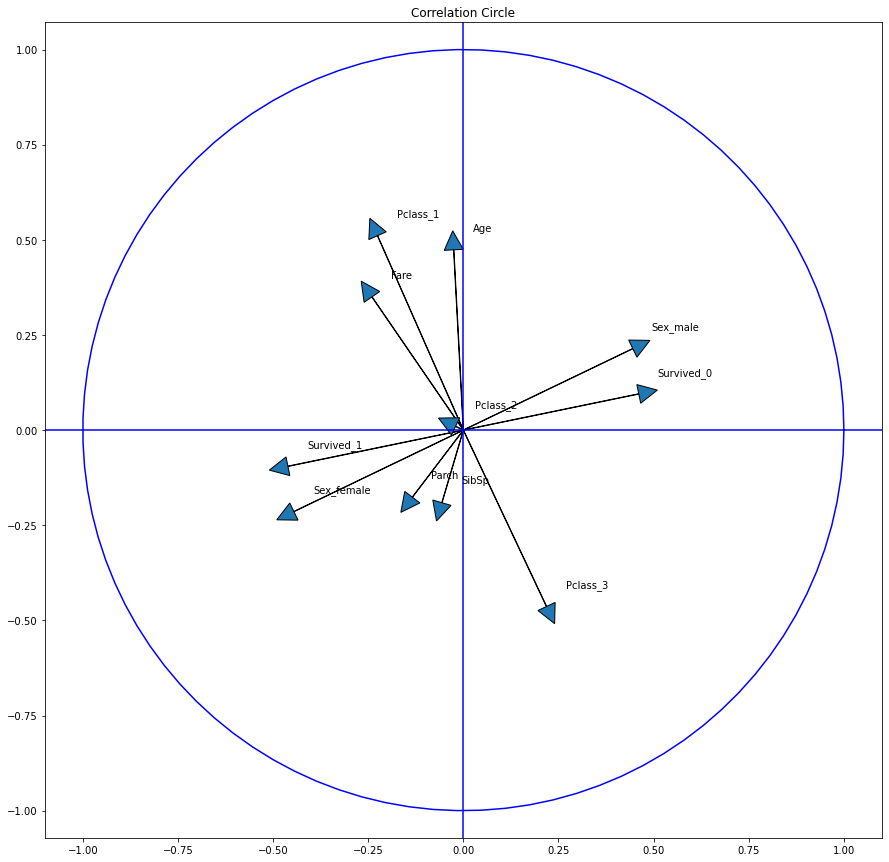

In [108]:
df1 = df.to_numpy()
pca = myPCA(df1)

pca.plot_PCA(df.Survived_1)
plot_corr_circle(df, pca.V)

Con respecto a los gráficos anteriores, se puede el gráfico de componentes principales que se forman 3 agrupaciones, una donde claramente los pasajeros murieron (rojo), otro donde sobrevivieron (azul), y un grupo en el centro donde parece que los valores están más mezclados, pero se puede decir que cuanto mayor sea el valor del PCA2, mayor fue la posibilidad de que el pasajero sobreviviera. Este fenómeno se puede explicar un poco con el círculo de correlación. Parece que el género tiene mucha influencia en el estado de la persona, los hombres tenían más posibilidad de morir que la las mujeres. Por otro lado, el comportamiento observado en el grupo central de primer gráfico parece ser explicado por la clase en que viajaba cada pasajero, las personas con la clase 1 (clase alta) tienen más probabilidad de sobrevivir que la personas con la clase 3 (clase baja)

# 3. Componentes principales con la biblioteca `sklearn`

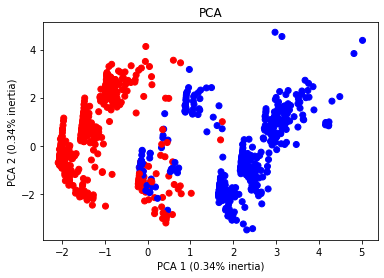

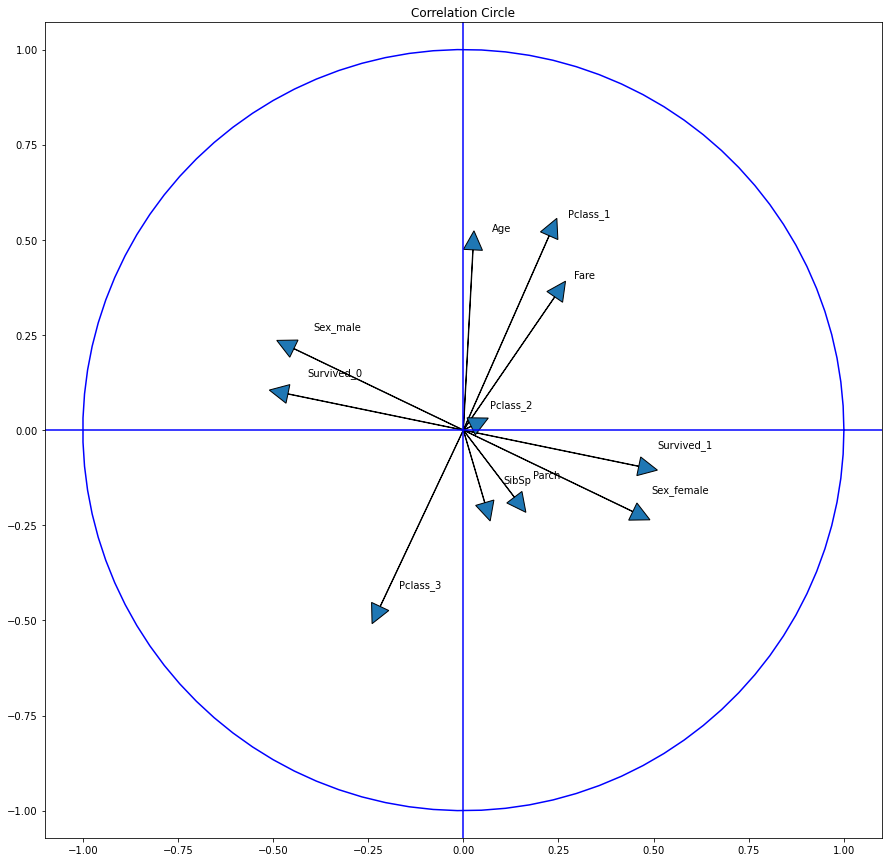

In [109]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
from sklearn.decomposition import PCA

pca = PCA()
C = pca.fit_transform(df_scaled)
inertia = pca.explained_variance_ratio_
V = pca.transform(np.identity(df_scaled.shape[1]))
plt.scatter(np.ravel(C[:,0]),np.ravel(C[:,1]),c = ['b' if i==1 else 'r' for i in df['Survived_1']])
plt.xlabel('PCA 1 (%.2f%% inertia)' % (inertia[0],))
plt.ylabel('PCA 2 (%.2f%% inertia)' % (inertia[0],))
plt.title('PCA')
plt.show()
plot_corr_circle(df,V)


Los gráficos producidos con `sklearn` y con myPCA no son tan distintos entre sí. Parece que está girado 90 grados en dirección contraria al reloj, pero por lo demás son idénticos. Este comportamiento no afecta al resultado ni al análisis del dataset con respecto a los componentes principales pues esta técnica consiste en aplicar transformaciones lineales sobre los datos. Esta diferencia solo muestra que los datos se están observando desde un ángulo distinto, pero son lo mismos. Esto puede ser debido a que algunos valores propios están en negativo. Por la naturaleza de los valores propios, que el valore sea negativo o positivo no afecta en la transformación lineal, solo cambian el ángulo en el que se observan los datos.